In [1]:
options(repr.plot.width=16, repr.plot.height=7, warn=-1)

Fit ARIMA models within last week’s framework

Fit Dynamic Linear Models/State Space Models.

# ARIMA models

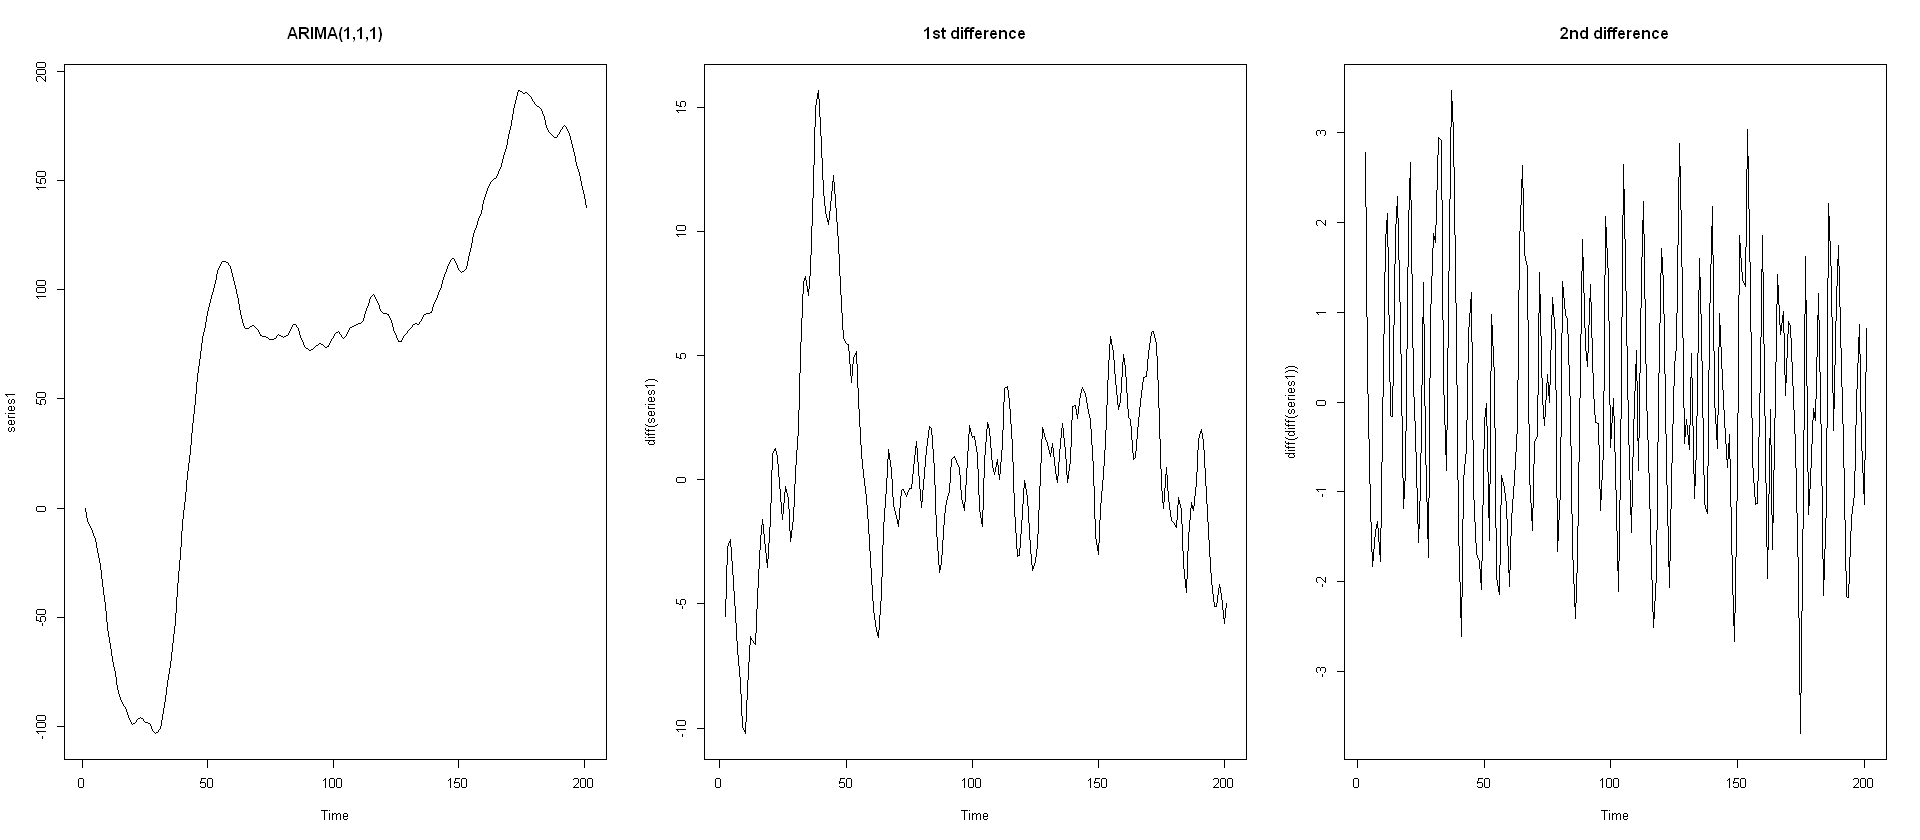

In [2]:
set.seed(673858)
series1 <- arima.sim(n = 200, list(order = c(1,1,1), ar = 0.9, ma = 0.9, sd = 1))
par(mfrow=c(1,3))
plot(series1, main = 'ARIMA(1,1,1)')
plot(diff(series1), main = '1st difference')
plot(diff(diff(series1)), main = '2nd difference')

In [3]:
model1 <- arima(series1, order = c(1,1,1))
model1


Call:
arima(x = series1, order = c(1, 1, 1))

Coefficients:
         ar1     ma1
      0.9099  0.8609
s.e.  0.0294  0.0357

sigma^2 estimated as 1.055:  log likelihood = -291.27,  aic = 588.54

In [4]:
library(forecast)
model1b <- auto.arima(series1, max.p=4, max.q=4, max.d=4, seasonal=FALSE)
model1b

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



Series: series1 
ARIMA(2,1,1) 

Coefficients:
         ar1      ar2     ma1
      1.0095  -0.1065  0.8302
s.e.  0.0841   0.0843  0.0497

sigma^2 estimated as 1.063:  log likelihood=-290.48
AIC=588.96   AICc=589.16   BIC=602.15

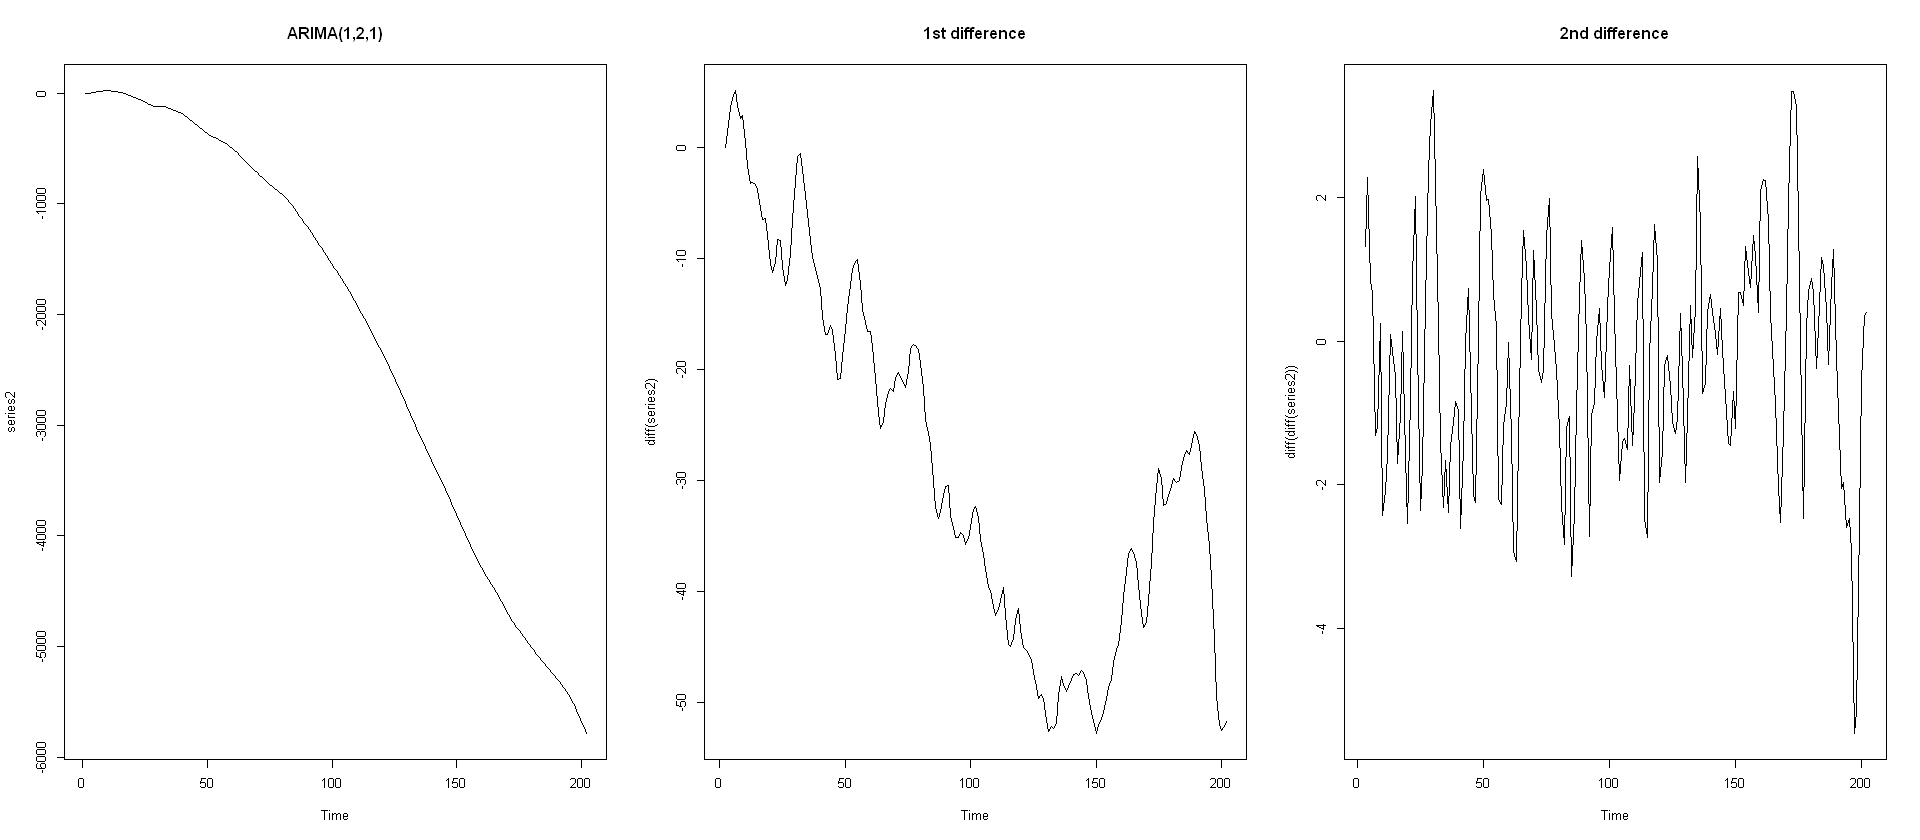

In [5]:
series2 <- arima.sim(n = 200, list(order = c(1,2,1), ar = 0.5, ma = 0.5, sd = 1))
par(mfrow=c(1,3))
plot(series2, main = 'ARIMA(1,2,1)')
plot(diff(series2), main = '1st difference')
plot(diff(diff(series2)), main = '2nd difference')

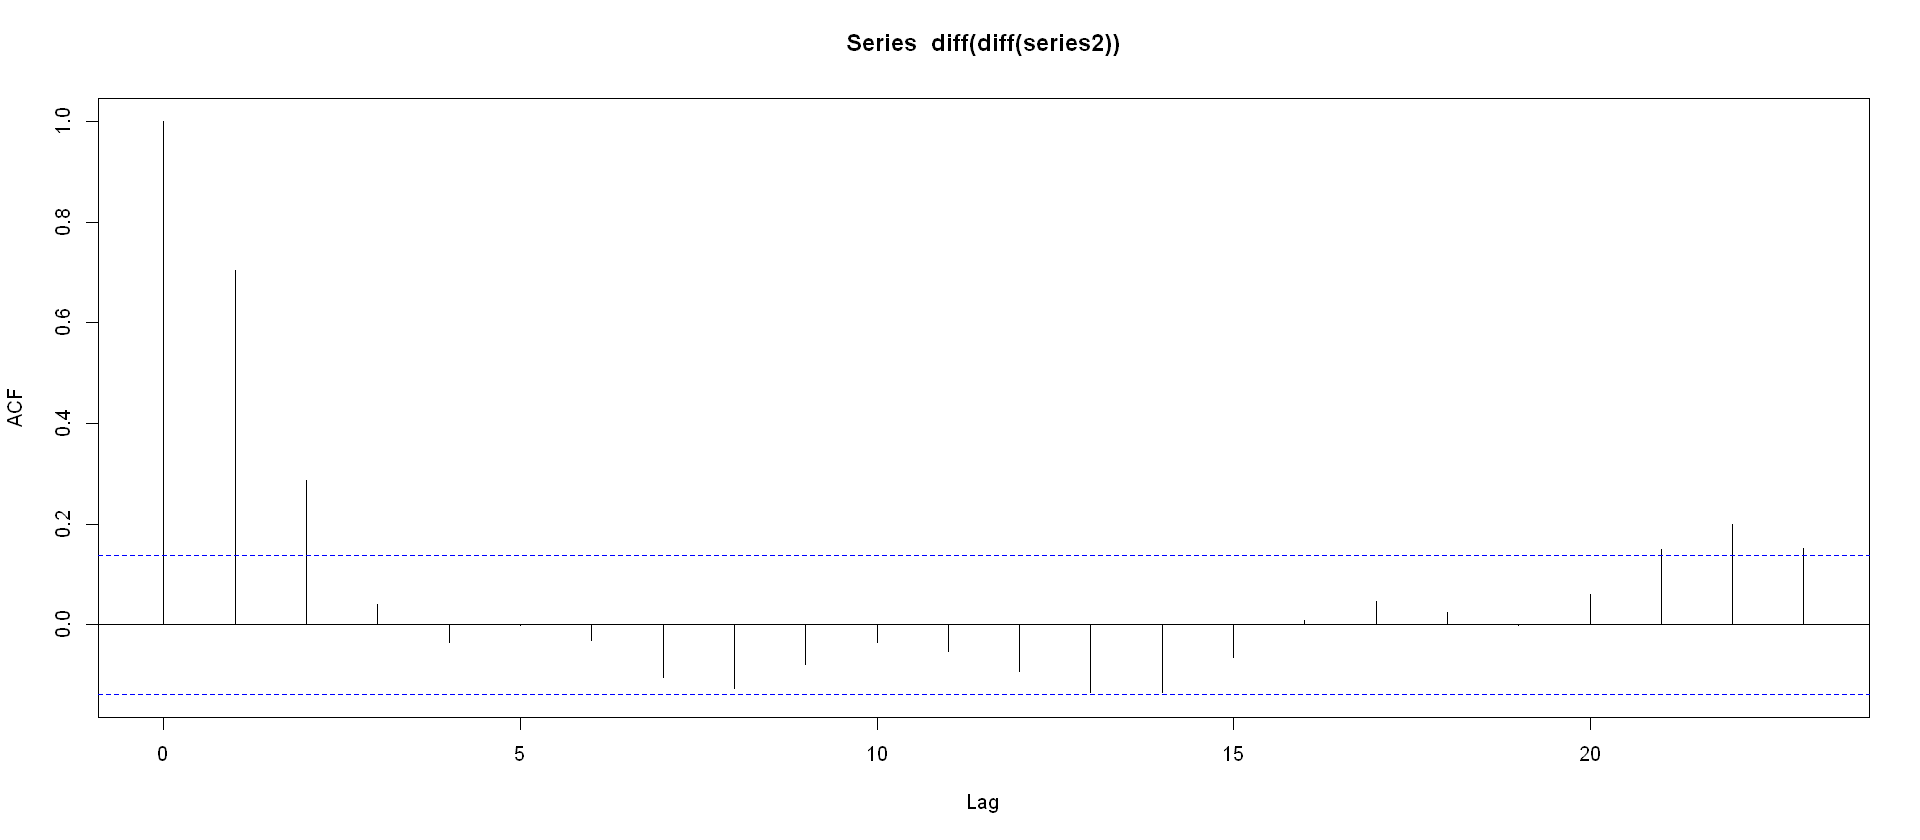

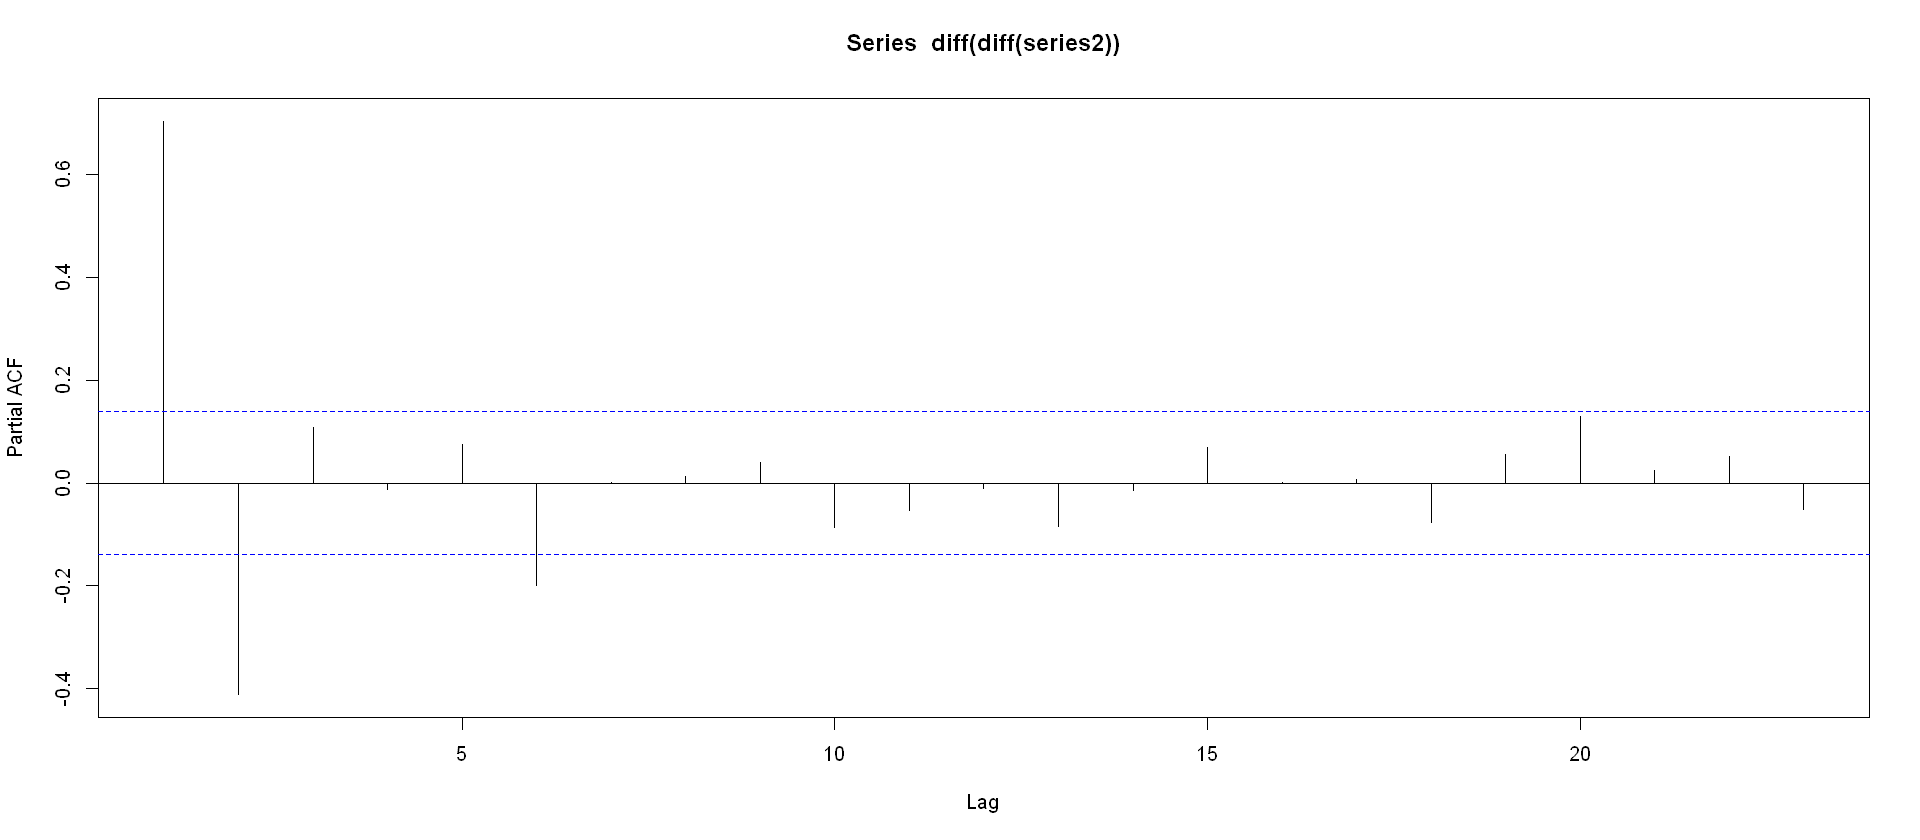

In [6]:
acf(diff(diff(series2)))
pacf(diff(diff(series2)))

# Dynamic Linear Models / State-Space Models

##### the model set up

$$ y_t = A_t x_t +v_t , v_t \sim N(0,R) $$
$$ x_t = \phi x_{t-1}+\omega_t, \omega_t \sim N(0,Q) $$

A matric cyclically choose the top Xt matrix value.

In [7]:
require(dlm)
seasonal_model <- dlmModSeas(4)
seasonal_model

# FF A matrix
# V  V variance 

# GG phi matrix
# W  W variance 

Loading required package: dlm



$FF
     [,1] [,2] [,3]
[1,]    1    0    0

$V
     [,1]
[1,]    1

$GG
     [,1] [,2] [,3]
[1,]   -1   -1   -1
[2,]    1    0    0
[3,]    0    1    0

$W
     [,1] [,2] [,3]
[1,]    1    0    0
[2,]    0    0    0
[3,]    0    0    0

$m0
[1] 0 0 0

$C0
      [,1]  [,2]  [,3]
[1,] 1e+07 0e+00 0e+00
[2,] 0e+00 1e+07 0e+00
[3,] 0e+00 0e+00 1e+07


In [8]:
seasonal_model$GG

-1,-1,-1
1,0,0
0,1,0


In [9]:
poly_model <- dlmModPoly(order=3)
poly_model$GG

1,1,0
0,1,1
0,0,1


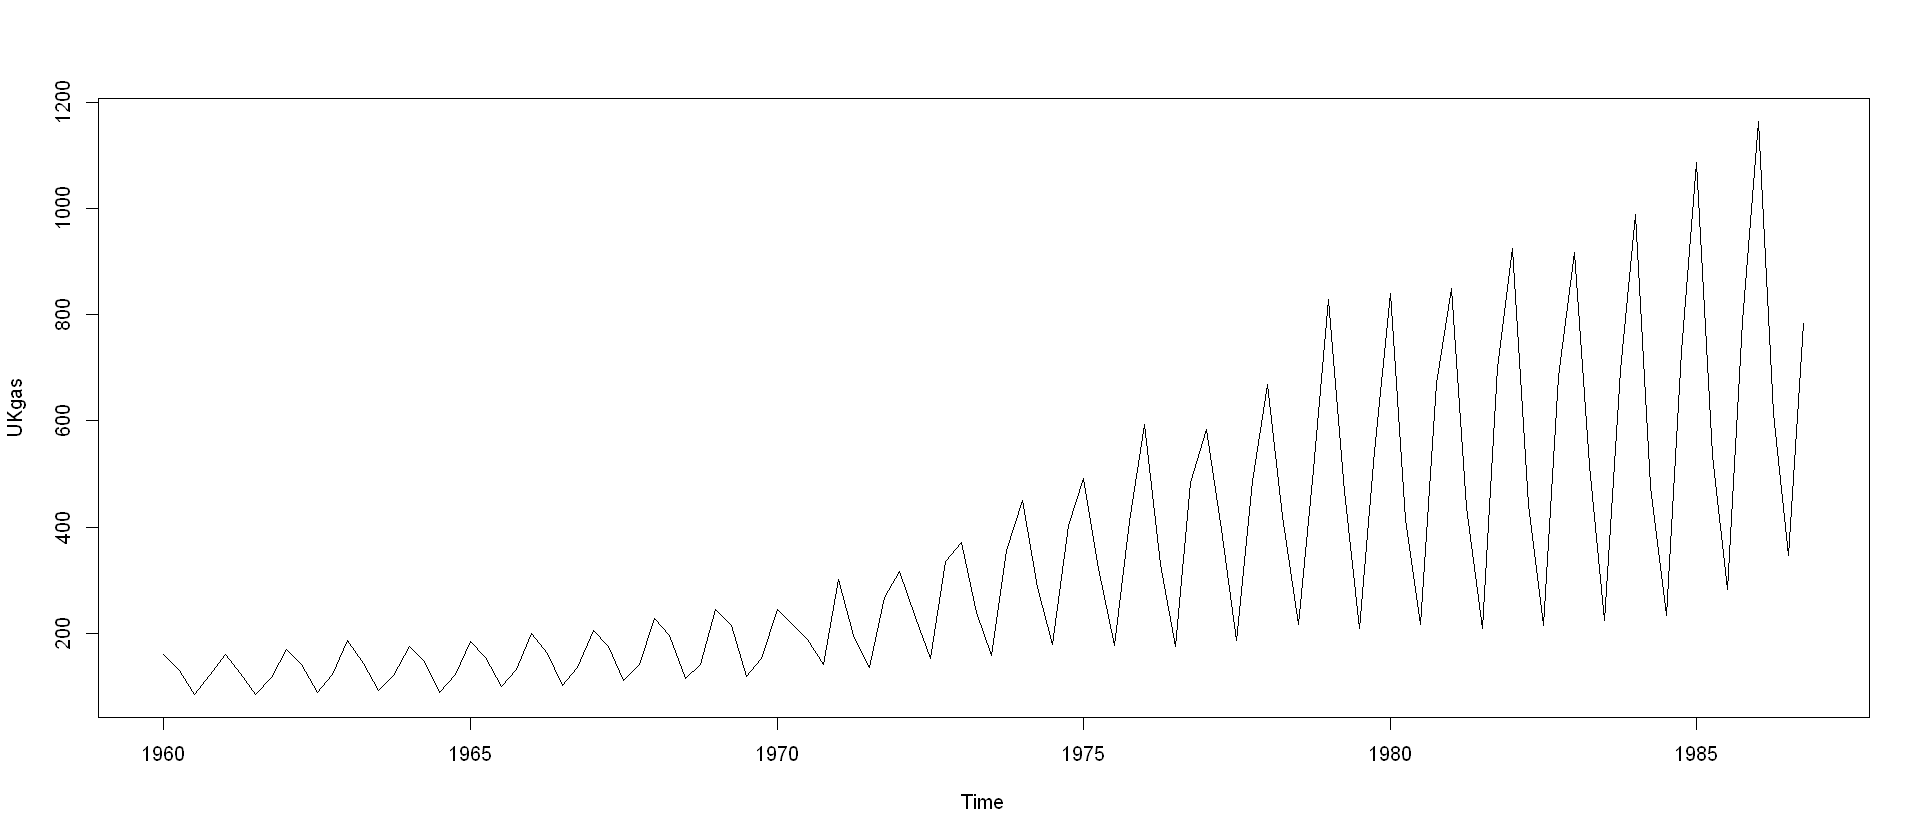

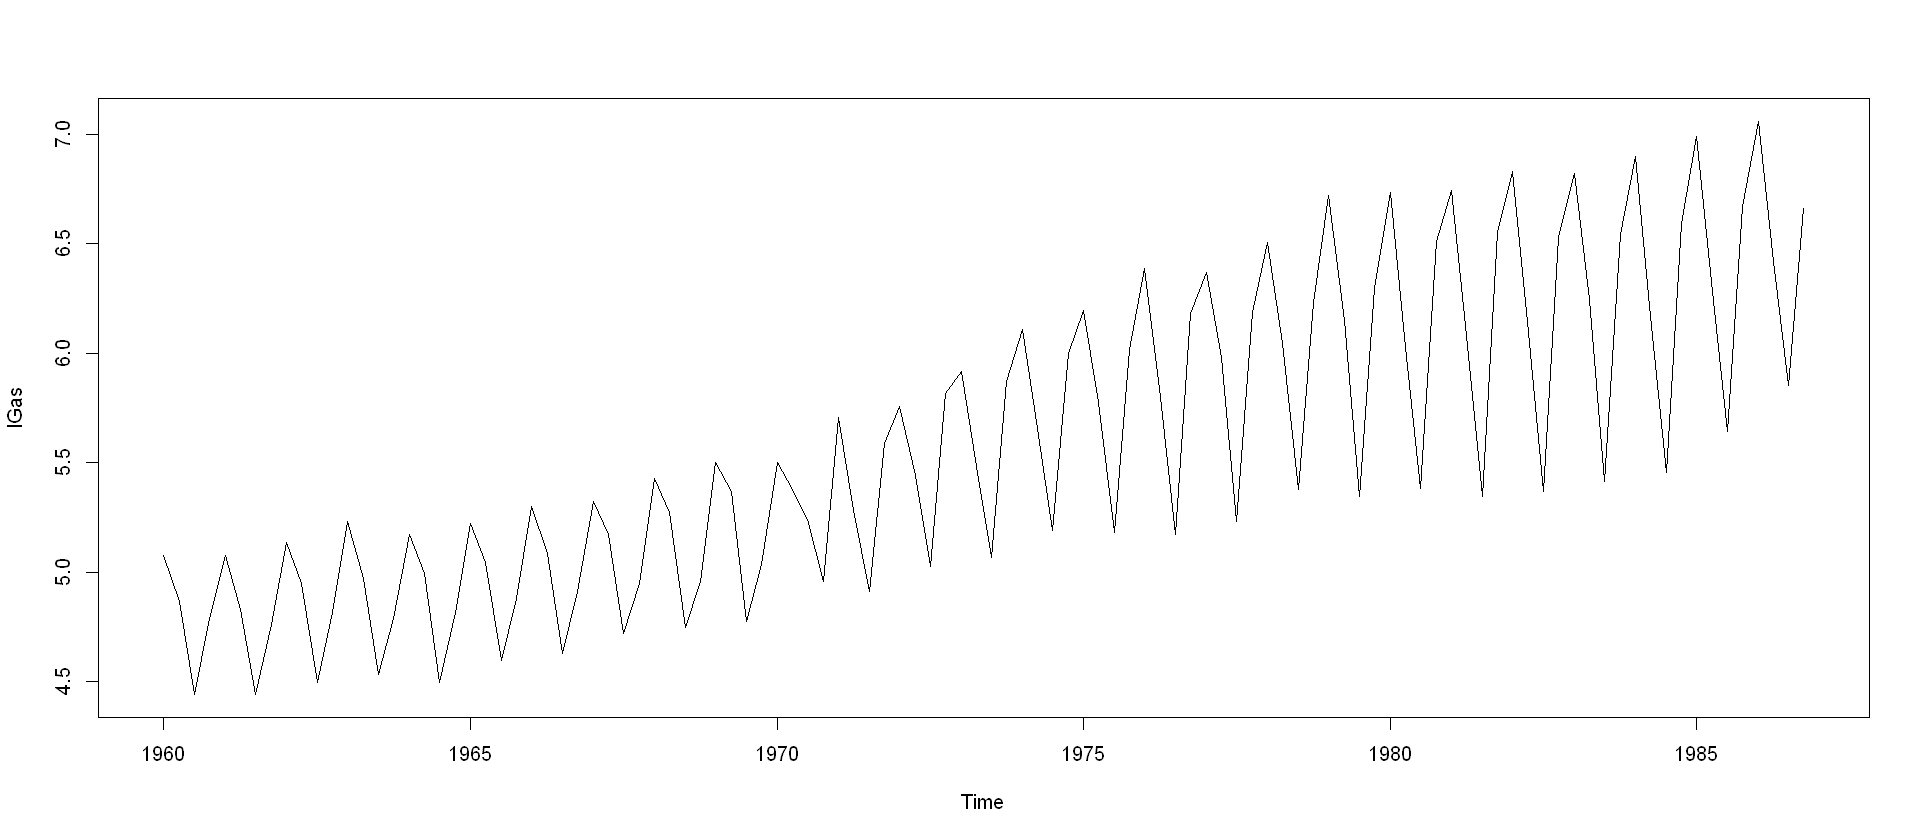

In [10]:
plot(UKgas)
lGas <- log(UKgas) # model log
plot(lGas)

In [11]:
dlmGas <- dlmModPoly(order = 2) + dlmModSeas(frequency = 4)
dlmGas$GG; dlmGas$W; dlmGas$FF

1,1,0,0,0
0,1,0,0,0
0,0,-1,-1,-1
0,0,1,0,0
0,0,0,1,0


0,0,0,0,0
0,1,0,0,0
0,0,1,0,0
0,0,0,0,0
0,0,0,0,0


1,0,1,0,0


In [12]:
buildFun <- function(x) {
    diag(W(dlmGas))[2:3] <- exp(x[1:2])
    V(dlmGas) <- exp(x[3])
    return(dlmGas)
}

In [13]:
fit <- dlmMLE(lGas, parm = rep(0, 3), build = buildFun)
fit$par

[1] -11.748487  -5.711233  -6.307548

In [14]:
dlmGas_fitted <- buildFun(fit$par)
V(dlmGas_fitted)

0.001822496


In [15]:
W(dlmGas_fitted)

0,0.000000e+00,0.000000000,0,0
0,7.901268e-06,0.000000000,0,0
0,0.000000e+00,0.003308592,0,0
0,0.000000e+00,0.000000000,0,0
0,0.000000e+00,0.000000000,0,0


In [16]:
gasSmooth <- dlmSmooth(lGas, mod = dlmGas_fitted)
summary(gasSmooth)

    Length Class  Mode   
s   545    mts    numeric
U.S 109    -none- list   
D.S 545    -none- numeric

In [17]:
dim(gasSmooth$s)

[1] 109   5

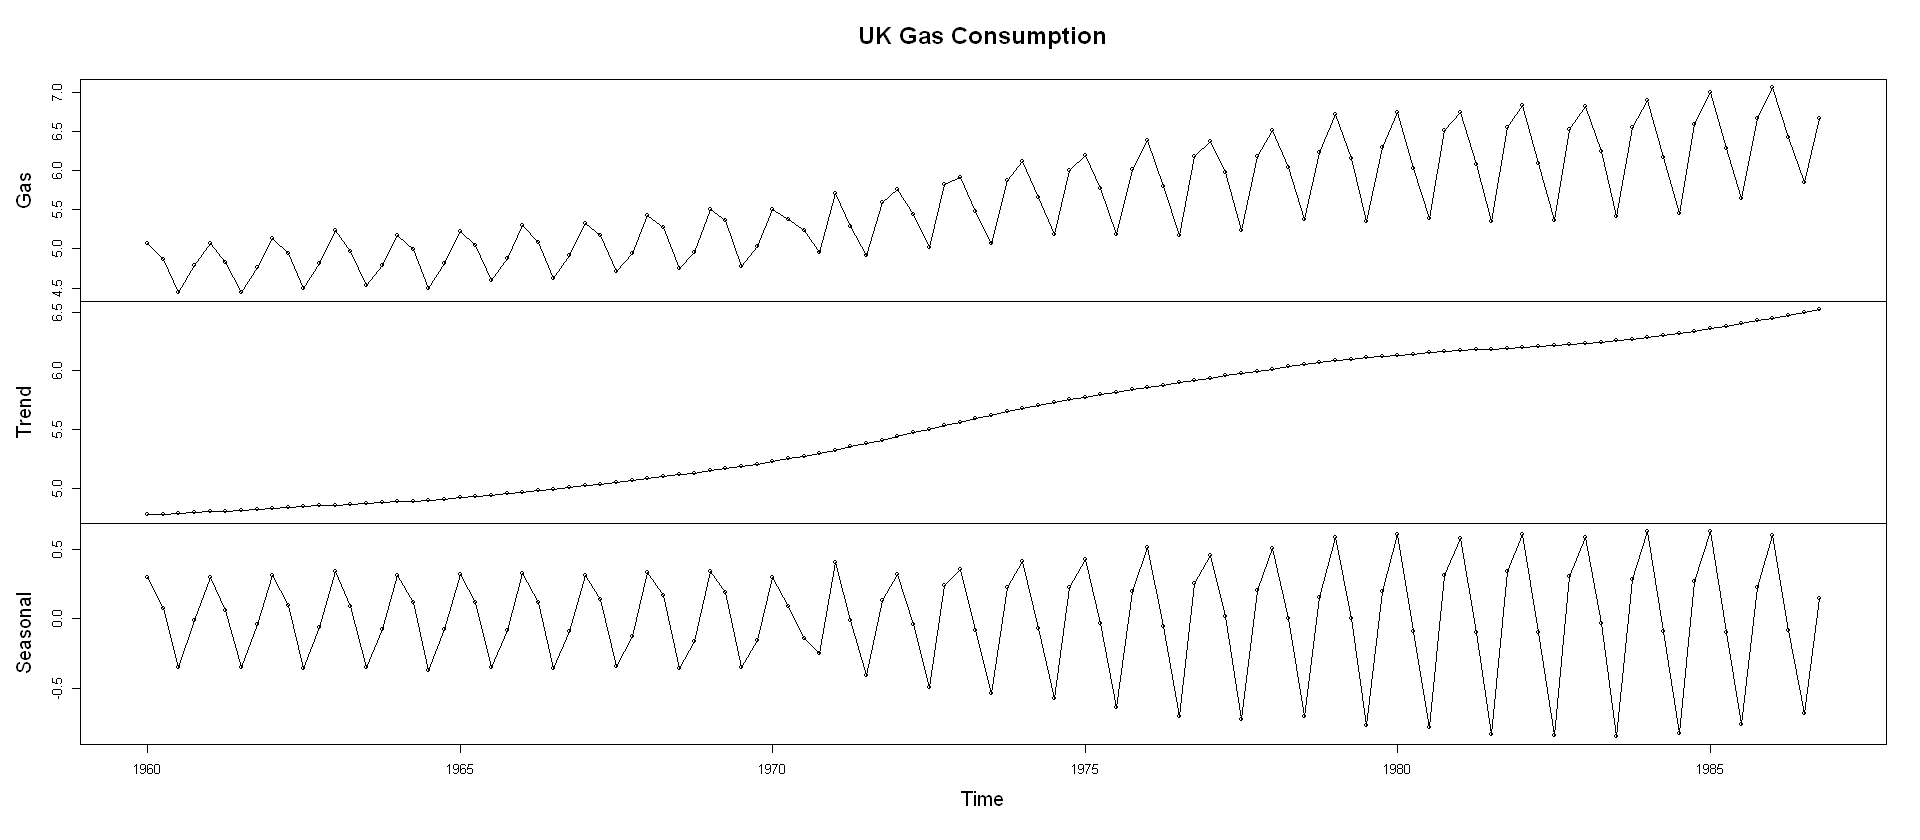

In [18]:
x <- cbind(lGas, dropFirst(gasSmooth$s[,c(1,3)]))
colnames(x) <- c("Gas", "Trend", "Seasonal")
plot(x, type = 'o', main = "UK Gas Consumption")

In [19]:
gasFilt <- dlmFilter(lGas, mod = dlmGas_fitted)
summary(gasFilt)

    Length Class  Mode   
y   108    ts     numeric
mod  10    dlm    list   
m   545    mts    numeric
U.C 109    -none- list   
D.C 545    -none- numeric
a   540    mts    numeric
U.R 108    -none- list   
D.R 540    -none- numeric
f   108    ts     numeric

In [20]:
dim(gasFilt$m)

[1] 109   5

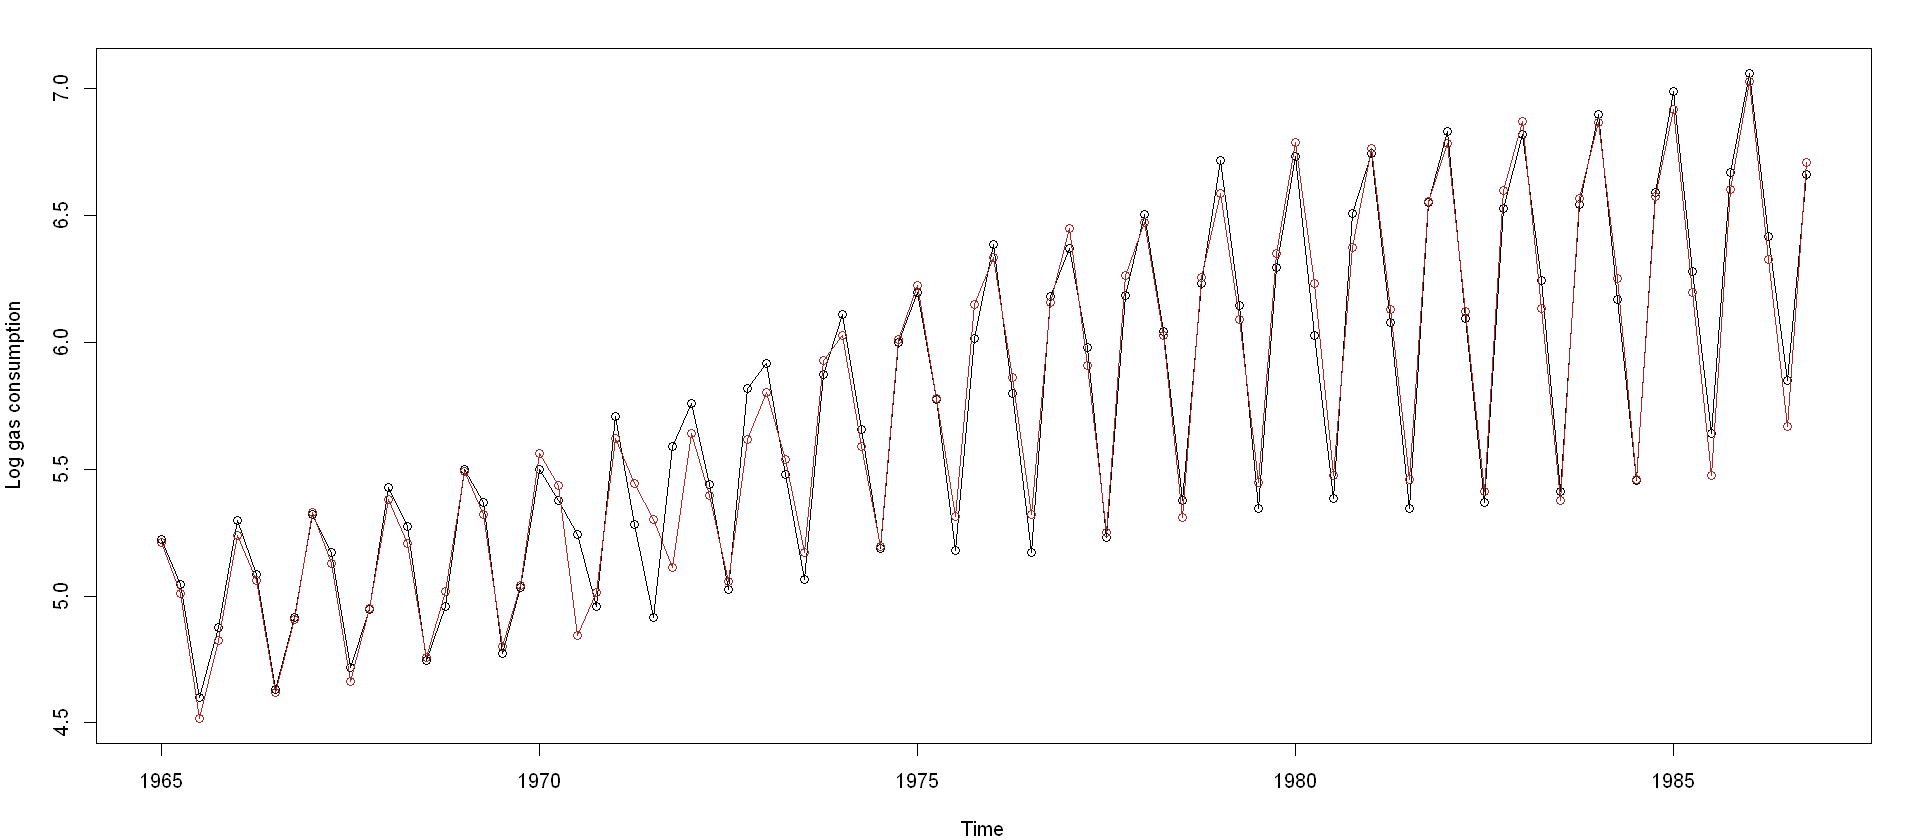

In [21]:
x <- ts.union(window(lGas, start = c(1965, 1)),
window(gasFilt$f, start = c(1965, 1)) )
par(mar = c(4,4,2,2))
plot(x, plot.type = "single", type = 'o',
     col = c("black","brown", "brown", "yellow", "yellow"),
     ylab = "Log gas consumption")

In [22]:
gasFore <- dlmForecast(gasFilt, nAhead = 20)
summary(gasFore)

  Length Class  Mode   
a 100    mts    numeric
R  20    -none- list   
f  20    ts     numeric
Q  20    -none- list   

In [23]:
dim(gasFore$a)

[1] 20  5

In [24]:
dim(gasFore$f)

[1] 20  1

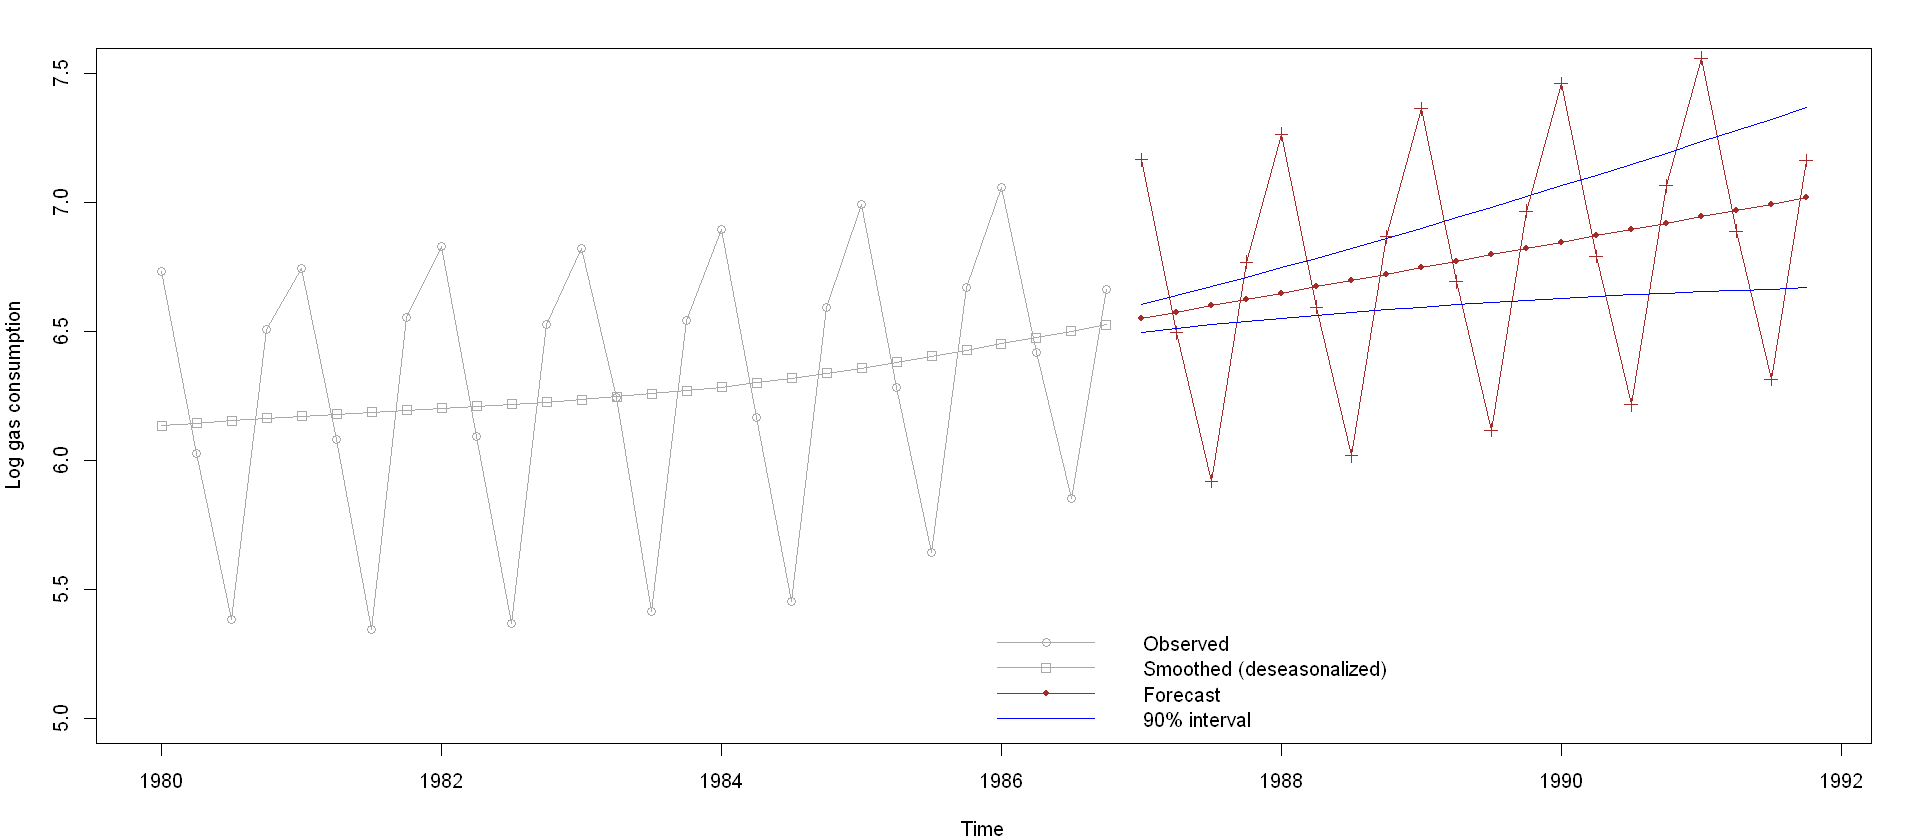

In [25]:
sqrtR <- sapply(gasFore$R, function(x) sqrt(x[1,1]))
pl <- gasFore$a[,1] + qnorm(0.05, sd = sqrtR)
pu <- gasFore$a[,1] + qnorm(0.95, sd = sqrtR)
x <- ts.union(window(lGas, start = c(1980, 1)),
window(gasSmooth$s[,1], start = c(1980, 1)),
gasFore$a[,1],
gasFore$f, pl, pu)
par(mar=c(4,4,2,2))
plot(x, plot.type = "single", type = 'o', pch = c(1, 0, 20, 3, NA, NA),
     col = c("darkgrey", "darkgrey", "brown", "brown", "blue", "blue"),
     ylab = "Log gas consumption", ylim = c(5, 7.5))
legend("bottomright", legend = c("Observed",
                                 "Smoothed (deseasonalized)",
                                 "Forecast", "90% interval"),
       bty = 'n', pch = c(1, 0, 20, NA), lty = 1,
       col = c("darkgrey", "darkgrey", "brown", "blue"))

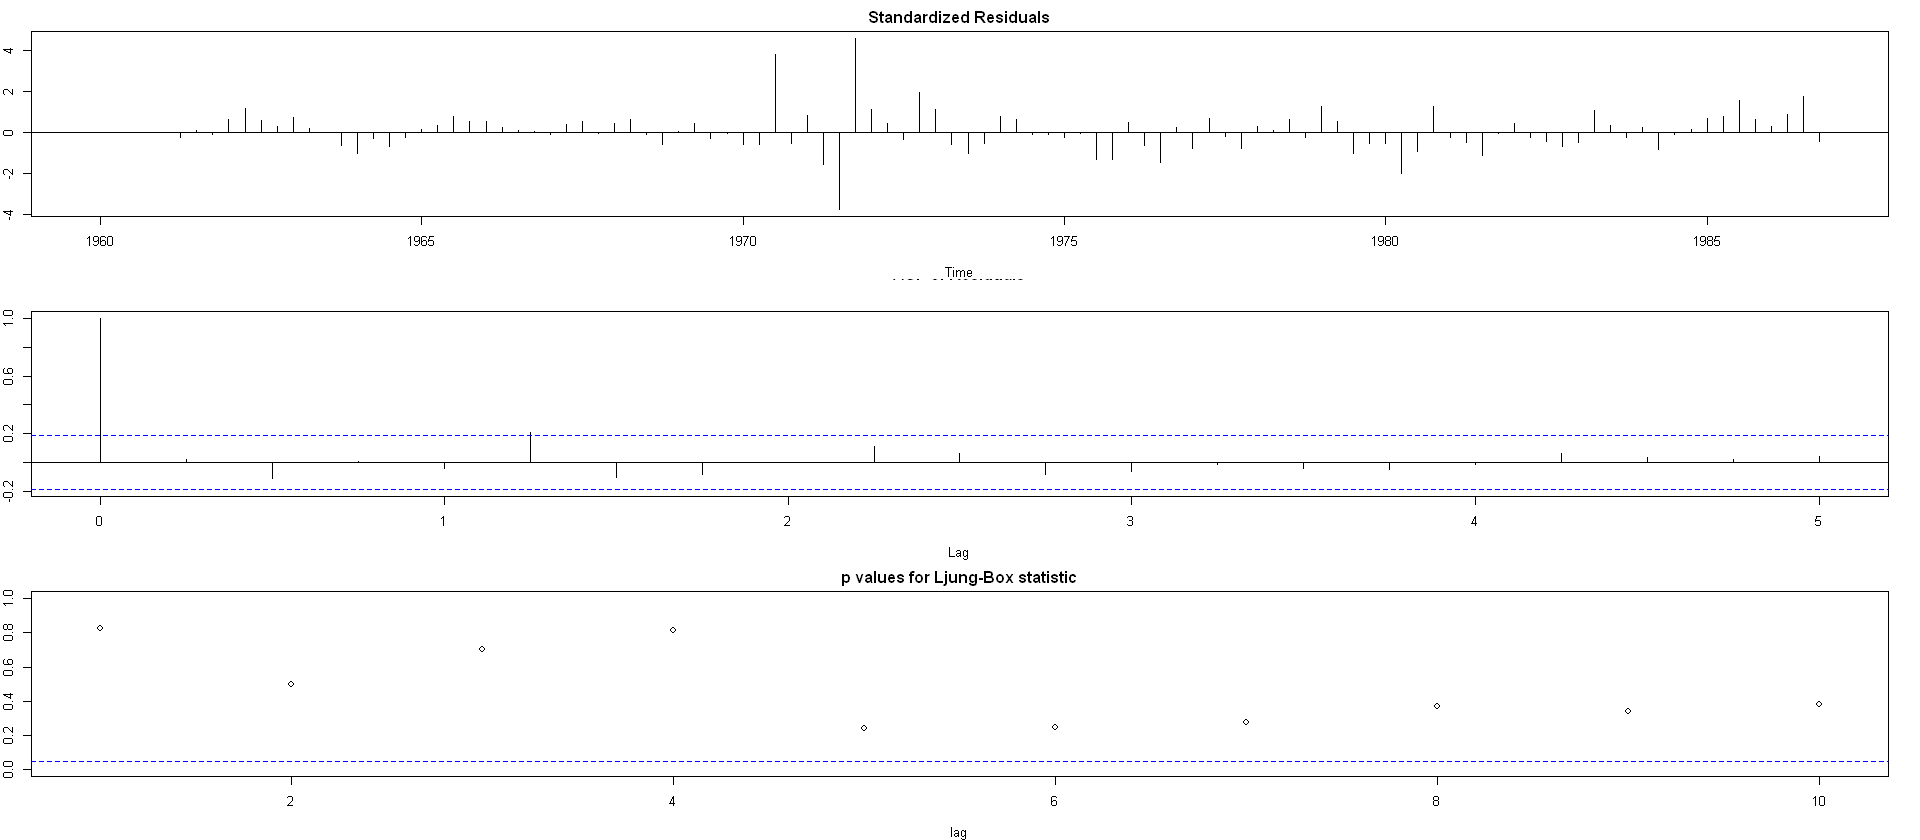

In [26]:
par(mar=c(4,2,2,2)); tsdiag(gasFilt)